# DoS ML Model

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

## Preprocessing data for binary classification (DoS (DDoS and DoS) or Benign)

In [2]:
from functions_ml import *

train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
y_column = 'label'

135 34


## Scaling

In [3]:
scaler = MinMaxScaler()

for train_set in tqdm(train_sets):
    scaler.fit(read_csv_file(train_set)[X_columns])

100%|██████████| 135/135 [01:31<00:00,  1.47it/s]


## Dictionnary for spliting data

In [3]:
dict_3_classes = {}
dict_3_classes['DDoS-RSTFINFlood'] = 'DoS'
dict_3_classes['DDoS-PSHACK_Flood'] = 'DoS'
dict_3_classes['DDoS-SYN_Flood'] = 'DoS'
dict_3_classes['DDoS-UDP_Flood'] = 'DoS'
dict_3_classes['DDoS-TCP_Flood'] = 'DoS'
dict_3_classes['DDoS-ICMP_Flood'] = 'DoS'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'DoS'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-SlowLoris'] = 'DoS'
dict_3_classes['DDoS-HTTP_Flood'] = 'DoS'
dict_3_classes['DoS-UDP_Flood'] = 'DoS'
dict_3_classes['DoS-SYN_Flood'] = 'DoS'
dict_3_classes['DoS-TCP_Flood'] = 'DoS'
dict_3_classes['DoS-HTTP_Flood'] = 'DoS'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

file_path = '.\Files\\DoS\\'

## Refactoring data

In [ ]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, scaler, file_path, X_columns, y_column)

100%|██████████| 168/168 [28:09<00:00, 10.06s/it]


## Counting number of samples per class

In [6]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

95


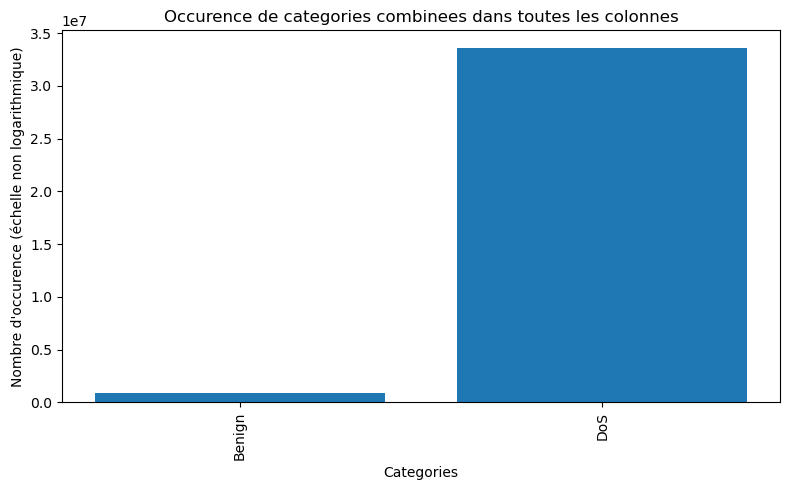

In [7]:
categorie_counts = count_label(train_sets, file_path=file_path)

plot_bar_chart(categorie_counts, 'Occurence de categories combinees dans toutes les colonnes', 'Categories', 'Nombre d\'occurence', 8, 5, log_scale=False)

## Buiding models

In [4]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
]

In [5]:
# Load data
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
print(len(X_columns[:-1]))
X_columns = X_columns[:-1]
y_column = 'label'
z_column = 'Binary'

# Data
X_train, y_train, z_train = get_all_sets_3_sets(train_sets, X_columns, y_column, z_column, path_to_datasets=file_path)
X_test, y_test, z_test = get_all_sets_3_sets(test_sets, X_columns, y_column, z_column, path_to_datasets=file_path)

# Define encoder and scaler
encoder = LabelEncoder()
scaler = StandardScaler()

# Define performance dataframe
performance = pd.DataFrame(columns=['Accuracy Training', 'Recall Training', 'Precision Training', 'F1 Training', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FP_rate', 'FN_rate', 'FP', 'FN', 'Total'])

# Buidling models
for model in tqdm(simpleModelsDef):
    # Path to DoS repository
    file_path = '.\\DoS_model\\'
    
    performance, scaler, encoder = build_model(model['Model'], X_train, y_train, X_test, y_test, performance, file_path, encoder, scaler, confusionMatrix=False)

performance.head()

95


46


  0%|          | 0/3 [11:21<?, ?it/s]


TypeError: 'bool' object is not callable

## Tests

In [ ]:


# {
#         "Name": "Voting",
#         "Model": VotingClassifier([
#             ('XGBClassifier', joblib.load('.\\Models\\TUNING\\model_XGB.joblib')),
#             ('DecisionTreeClassifier', joblib.load('.\\Models\\TUNING\\model_DT.joblib')),
#             ('RandomForestClassifier', joblib.load('.\\Models\\TUNING\\model_RF.joblib')),
#             ],
#             voting='soft')
# }

In [7]:
import gc
gc.collect()

1276